# Fine-tune GIT on a custom dataset for image captioning

In this notebook, we'll fine-tune [GIT](https://huggingface.co/docs/transformers/main/en/model_doc/git), short for GenerativeImage2Text, on a toy image captioning dataset.

GIT is, at the moment of writing, a state-of-the-art image/video captioning and question answering (QA) model.

## Set-up environment

First, let's install 🤗 Transformers as well as 🤗 Datasets.

In [2]:
# Environment dependencies: torch, transformers, datasets, matplotlib, Pillow
# CLI Installation: !pip install *package* 

## Create image captioning dataset

Next, we'll create a tiny image captioning dataset, which as you might have guessed consists of (image, text) pairs.

We'll follow the guide [here](https://huggingface.co/docs/datasets/main/en/image_dataset#image-captioning) to create a 🤗 Dataset, which allows for very fast processing. Basically, we need to add a metadata.jsonl file to our folder containing the images. This metadata file contains the captions, for each of the images.

In [3]:
import json

# path to the folder containing the images
root = "Image"


Our metadata.json file contains the three following attributes for each randomly sampled image:

"name": the name of the image. For the sake of simplicity, our 50 randomly sampled images are named "k.jpg" where k ranges from 0 to 49.

"label": the food class the image belongs to, e.g. 'ice cream', 'guacamole', 'samosa'...

"annotation": hand-written caption of the image. A labeler of our team subjectively described each of the 50 images.

WARNING: the images and the .json rows need to be sorted in the same order, and the images are named "k.jpg" where k ranges from 0 to 49.

In [4]:
captions = []

# add metadata.jsonl file to this folder
with open(root + "/metadata.json") as f:
    data=json.load(f)
    #captions = [{"nom":str(k)+".jpg","label":item['name'], "annotation":item['annotation']} for (k,item) in (range(50),data)]
    captions = [{"nom": str(k) + ".jpg", "label": item['name'], "annotation": item['annotation']} for k, item in enumerate(data[:50])]


Let's verify if each of the three attributes is correctly appended:

In [6]:
print(captions)

[{'nom': '0.jpg', 'label': 'ice_cream', 'annotation': 'topping planted inside a white, creamy and fluffy ice cream inside a cone'}, {'nom': '1.jpg', 'label': 'guacamole', 'annotation': 'guacamole with pomegranate seed, salad, piece of tomato, sliced parsley and onion in a yellow bowl with a spoon planted inside'}, {'nom': '2.jpg', 'label': 'crab_cakes', 'annotation': 'two fried crab cakes with corn, cabbage in salad in a plat'}, {'nom': '3.jpg', 'label': 'ice_cream', 'annotation': 'small chocolat cake in a cup, with biscuit topping planted inside, above tubs of ice cream with lots of different flavors'}, {'nom': '4.jpg', 'label': 'pizza', 'annotation': 'two slices of a pizza with peperoni and beef meat on a wooden table'}, {'nom': '5.jpg', 'label': 'french_fries', 'annotation': 'plat of french fries in on side and with lemon, onion, carrot and green bean in the other side'}, {'nom': '6.jpg', 'label': 'pizza', 'annotation': 'Delicious looking cheese pizza sliced in eight with another sa

# Making a custom Hugging Face dataset

Next, we use the [ImageFolder](https://huggingface.co/docs/datasets/main/en/image_dataset#imagefolder) feature to quickly turn this into a 🤗 Dataset. We'll specify that this is just the training split of the dataset.

The custom dataset is a dictionary of 4 attributes:

"image": the image file itself.

"name": the name of the image. For the sake of simplicity, our 50 randomly sampled images are named "k.jpg" where k ranges from 0 to 49.

"label": the food class the image belongs to, e.g. 'ice cream', 'guacamole', 'samosa'...

"annotation": hand-written caption of the image. A labeler of our team subjectively described each of the 50 images.

In [7]:
from datasets import load_dataset
import json

# Load image data
dataset = load_dataset("imagefolder", data_dir=root, split="train")
image_paths = dataset['image']

# Load metadata from JSON
with open(root + "/metadata.json") as f:
    metadata = json.load(f)

# Combine data
custom_dataset = []
for i, image_path in enumerate(image_paths):
    if i < len(metadata):
        item = {
            "image": image_path,
            "nom": str(i) + ".jpg",
            "label": metadata[i]['name'],
            "annotation": metadata[i]['annotation']
        }
        custom_dataset.append(item)
    else:
        # Handle the case where there is no metadata for an image
        pass

/data/project/tsouthiratn/miniconda3/envs/tutorial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 51/51 [00:00<00:00, 204307.07it/s]


Let's check whether the dataset is created correctly:

In [8]:
custom_dataset

[{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
  'nom': '0.jpg',
  'label': 'ice_cream',
  'annotation': 'topping planted inside a white, creamy and fluffy ice cream inside a cone'},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=382x512>,
  'nom': '1.jpg',
  'label': 'guacamole',
  'annotation': 'guacamole with pomegranate seed, salad, piece of tomato, sliced parsley and onion in a yellow bowl with a spoon planted inside'},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=288x512>,
  'nom': '2.jpg',
  'label': 'crab_cakes',
  'annotation': 'two fried crab cakes with corn, cabbage in salad in a plat'},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=425x512>,
  'nom': '3.jpg',
  'label': 'ice_cream',
  'annotation': 'small chocolat cake in a cup, with biscuit topping planted inside, above tubs of ice cream with lots of different flavors'},
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,

Let's take a look at one example:

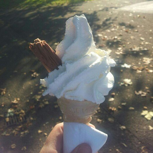

In [9]:
example = custom_dataset[0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

Let's check its corresponding attributes:

In [10]:
example["nom"]

'0.jpg'

In [11]:
example["label"]

'ice_cream'

In [12]:
example["annotation"]

'topping planted inside a white, creamy and fluffy ice cream inside a cone'

## Create PyTorch Dataset

Next, we create a standard [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). Each item of the dataset returns the expected inputs for the model, in this case input_ids, attention_mask and pixel_values.

We use `GitProcessor` to turn each (image, text) pair into the expected inputs. Basically, the text gets turned into `input_ids` and `attention_mask`, and the image gets turned into `pixel_values`.

In [13]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["annotation"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        return encoding

In [14]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [15]:
train_dataset = ImageCaptioningDataset(custom_dataset, processor)

Let's check one example of the dataset:

In [16]:
print(type(train_dataset))

<class '__main__.ImageCaptioningDataset'>


In [17]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


## Create PyTorch DataLoader

Next, we create a corresponding [PyTorch DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allows us to get batches of data from the dataset.

We need this as neural networks (like GIT) are trained on batches of data, using stochastic gradient descent (SGD).

In [18]:
#from torch.utils.data import DataLoader

#train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [19]:
from torch.utils.data import random_split, DataLoader

# Assuming train_dataset contains 50 samples
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split train_dataset into train_dataset and validation_dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=2)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


Let's check one batch, and do some sanity checks. We can decode the input_ids back into text for instance:

In [21]:
processor.decode(batch["input_ids"][0])

'[CLS] open samosa [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

We can "denormalize" the pixel values to get back an image:

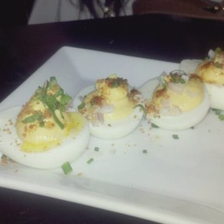

In [22]:
from PIL import Image
import numpy as np

MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Looks ok! Always important to check your data ;) see [this blog](http://karpathy.github.io/2019/04/25/recipe/) for a great overview of tips when training neural networks.

## Define model

Next, we instantiate a model. We start from the pre-trained GIT-base model (which was already pre-trained on 4 million image-text pairs by Microsoft).

Of course, feel free to start fine-tuning another GIT model from the [hub](https://huggingface.co/models?other=git).

In [23]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

## Dummy forward pass

It's always good to check the initial loss on a batch. See also the blog above.

In [24]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(12.2992, grad_fn=<NllLossBackward0>)

## Train the model

Next, let's train the model! We use native PyTorch here.

As I created a super tiny dataset just for demo purposes, we'll let the model overfit it. If it's capable of overfitting it (i.e. achieve zero loss), then that's a great way to know that everything is working properly. See also the blog above.

## Training + Validation

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Training Loss: 12.49753189086914
Training Loss: 10.595449447631836
Training Loss: 10.068727493286133
Training Loss: 9.798190116882324
Training Loss: 9.605892181396484
Training Loss: 9.401344299316406
Training Loss: 9.214015007019043
Training Loss: 9.094161987304688
Training Loss: 8.854358673095703
Training Loss: 8.677099227905273
Training Loss: 8.57648754119873
Training Loss: 8.420173645019531
Training Loss: 8.281289100646973
Training Loss: 8.192572593688965
Training Loss: 8.132600784301758
Training Loss: 8.016520500183105
Training Loss: 7.94569206237793
Training Loss: 7.826887607574463
Training Loss: 7.73813009262085
Training Loss: 7.571413040161133
Average Training Loss: 8.925426864624024
Average Validation Loss: 7.40625524520874
Epoch: 1
Training Loss: 7.466236591339111
Training Loss: 7.336920261383057
Training Loss: 7.288476467132568
Training Loss: 7.1432294845581055
Training Loss: 7.107481002807617
Training Loss: 6.96036434173584
Training Loss: 6.890614986419678
Training 

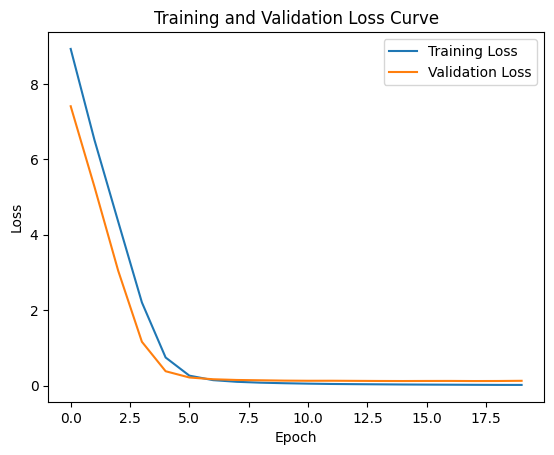

In [25]:
import torch
import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda:2" if torch.cuda.is_available() else "cpu"
model.to(device)

# Assuming you have a separate validation dataloader
validation_losses = []

model.train()

# Initialize an empty list to store training losses
training_losses = []

for epoch in range(20):
    print("Epoch:", epoch)
    epoch_losses = []

    # Training phase
    model.train()
    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        epoch_losses.append(loss.item())

        print("Training Loss:", loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Calculate and print the average training loss for the epoch
    average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print("Average Training Loss:", average_epoch_loss)

    # Store the average training loss for plotting
    training_losses.append(average_epoch_loss)

    # Validation phase
    model.eval()
    with torch.no_grad():
        validation_epoch_losses = []
        for idx, val_batch in enumerate(validation_dataloader):
            val_input_ids = val_batch.pop("input_ids").to(device)
            val_pixel_values = val_batch.pop("pixel_values").to(device)

            val_outputs = model(input_ids=val_input_ids,
                                pixel_values=val_pixel_values,
                                labels=val_input_ids)

            val_loss = val_outputs.loss
            validation_epoch_losses.append(val_loss.item())

        # Calculate and print the average validation loss for the epoch
        average_validation_loss = sum(validation_epoch_losses) / len(validation_epoch_losses)
        print("Average Validation Loss:", average_validation_loss)

        # Store the average validation loss for plotting
        validation_losses.append(average_validation_loss)

# Plot the training and validation loss curves on the same plot
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

## Train - No Validation

In [ ]:
""" import torch
import matplotlib.pyplot as plt

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda:2" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

# Initialize an empty list to store training losses
training_losses = []

for epoch in range(20):
    print("Epoch:", epoch)
    epoch_losses = []

    for idx, batch in enumerate(train_dataloader):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)

        loss = outputs.loss
        epoch_losses.append(loss.item())

        print("Loss:", loss.item())

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

    # Calculate and print the average loss for the epoch
    average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print("Average Epoch Loss:", average_epoch_loss)

    # Store the average epoch loss for plotting
    training_losses.append(average_epoch_loss)

# Plot the training loss curve
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show() """


## Inference

Now that we've trained the model, let's load a random food image and perform inference on it.

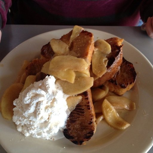

In [119]:
# load image
example = dataset[21]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [120]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

bowl of guacamole with sliced tomatos and onion


Great! We've successfully fine-tuned GIT on our tiny (image, text) dataset to generate captions of images of Food101.

WARNING: Inference is only limited to the 10 random classes sampled at the very beginning of our study.

### Saving Data as numpy arrays

In [ ]:
#how to save numpy arrays
array = np.array([1,2,3])
filename = "data/hi.npy"
np.save(array, filename)